## imports

In [1]:
import __init__
from __init__ import DATA_PATH
from __init__ import PACKAGE_PATH
from dce import DCE
from cluster import Cluster
from descriptor import rdkitDescriptors
import utilities
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


## read data and generate descriptors
* ground_truth using 60% BOD cut
* descriptor using float here

Number of Descriptor:68


(array([756.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 307.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

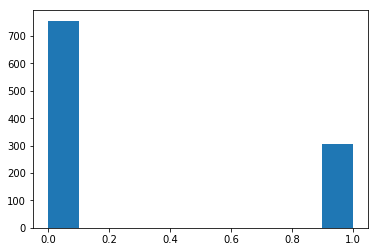

In [2]:
df = pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))
df['cleaned_bod'] = utilities.clean_out_of_bound(df['value (% BOD)'])
feat_float = rdkitDescriptors.batch_compute_all_descriptors(df['SMILES'],desc_type='float')
selected_float_feat = feat_float.loc[:,feat_float.nunique()>1]
print('Number of Descriptor:' + str(len(selected_float_feat.loc[0])))
      
df['bi_class_partition'] = utilities.divide_classes(df['cleaned_bod'], [60])
true_label_biclass = df['bi_class_partition'].values
plt.hist(df['bi_class_partition'])

## build model and train model

In [3]:
autoencoder_dims = [68,45,20]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=50)
dce.build_model()

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
dce.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 68)           0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 68)           272         input[0][0]                      
__________________________________________________________________________________________________
encoder_0 (Dense)               (None, 45)           3105        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
embedding_layer (Dense)         (None, 20)           920         encoder_0[0][0]                  
__________________________________________________________________________________________________
decoder_1 

In [5]:
[y_pred, loss, delta_label] = dce.train_model(selected_float_feat.values,clustering_loss='kld', 
                                              decoder_loss='mse', clustering_loss_weight=0.5)

Instructions for updating:
Use tf.cast instead.
Epoch: 0
  Total_loss = 0.015502067;Delta_label = 0.0
  Clustering_loss = 0.00036636388; Decoder_loss = 0.03063777
Epoch: 50
  Total_loss = 0.00048071414;Delta_label = 0.21448730009407338
  Clustering_loss = 1.5087178e-05; Decoder_loss = 0.0009463411
Epoch: 100
  Total_loss = 0.00044570462;Delta_label = 0.04609595484477893
  Clustering_loss = 5.53932e-05; Decoder_loss = 0.000836016
Epoch: 150
  Total_loss = 0.00048976345;Delta_label = 0.036688617121354655
  Clustering_loss = 0.00021248212; Decoder_loss = 0.0007670448
Epoch: 200
  Total_loss = 0.0007484655;Delta_label = 0.03198494825964252
  Clustering_loss = 0.0008010449; Decoder_loss = 0.00069588603
Epoch: 250
  Total_loss = 0.0017573577;Delta_label = 0.023518344308560677
  Clustering_loss = 0.0028723876; Decoder_loss = 0.0006423278
Epoch: 300
  Total_loss = 0.00474827;Delta_label = 0.024459078080903106
  Clustering_loss = 0.008890387; Decoder_loss = 0.0006061536
Epoch: 350
  Total_loss 

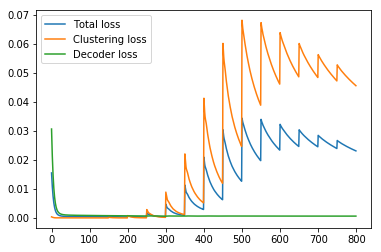

In [6]:
plt.plot(loss[0], label='Total loss')
plt.plot(loss[1], label='Clustering loss')
plt.plot(loss[2], label='Decoder loss')
plt.legend()

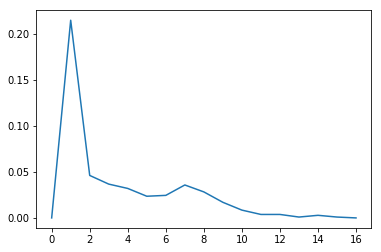

In [7]:
plt.plot(delta_label)

(array([593.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 470.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

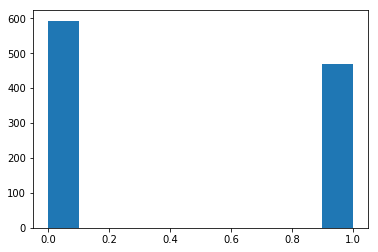

In [8]:
plt.hist(y_pred)

In [9]:
Cluster.true_label_metrics(true_label_biclass,y_pred,print_metric=True)

Metric with True label
adjusted rand score: -0.0015204743979484498 
fowlkes_mallows : 0.545270611189934


{'adjusted_rand_score': -0.0015204743979484498,
 'fowlkes_mallows_score': 0.545270611189934}